# StegoPack - Analysis

In [1]:
# Import main library
from StegoPack import Image, Payload

In [2]:
# Helper functions to demo via Jupyter Notebook

import os
from os.path import join as dirPath
baseDir = "demo_files"
payloadsDir = dirPath(baseDir, "payloads")
encodedDir = dirPath(baseDir, "encoded")

import numpy as np
import imageio
import matplotlib.pyplot as plt
def pltshow(a, b=None, dim=(1,1)):
    plt.figure(figsize=(20 * dim[0]/dim[1], 20))
    plt.subplots_adjust(left=.01, bottom=.01, right=.99, top=.99, wspace=.1, hspace=.1)
    
    plt.subplot(121)
    plt.imshow(imageio.imread(a))
    plt.axis("off")
    if b:
        plt.subplot(122)
        plt.imshow(imageio.imread(b))
        plt.axis("off")
    plt.show()

# Create demo subdirectory
try: os.mkdir(encodedDir)
except: pass

## "Worst-Case Scenario" Demo

Image: `randall-2560x1372.png`

Payload: `payloads/pier39.mp4`

Output (Image with payload): `encoded/randall-L2.png`

Fill with random noise: `False`

In [3]:
image = Image(dirPath(baseDir, "randall-2560x1372.png"))
image.printInfo()

payload = Payload(dirPath(payloadsDir, "pier39.mp4"))
payload.printInfo()

# Encoding
image.encodePayload(payload, fillRandom=False)
image.saveFile(dirPath(encodedDir, "randall-L2.png"))

# Decoding
image = Image(dirPath(encodedDir, "randall-L2.png"))
payload = image.decodePayload()
# payload.saveFile()

'demo_files\randall-2560x1372.png' has file size 1.2 MB and dimensions 1372x2560 (3512320 pixels).
Payload storage capacities (including payload header):
  Level 0: up to 1.3 MB
  Level 1: 1.3 MB to 2.5 MB
  Level 2: 2.5 MB to 5.0 MB
'pier39.mp4' needs 3.2 MB of payload storage.
Encoding 'pier39.mp4' into 'demo_files\randall-2560x1372.png' using L2...
File 'pier39.mp4' found encoded as L2!
Decoding...


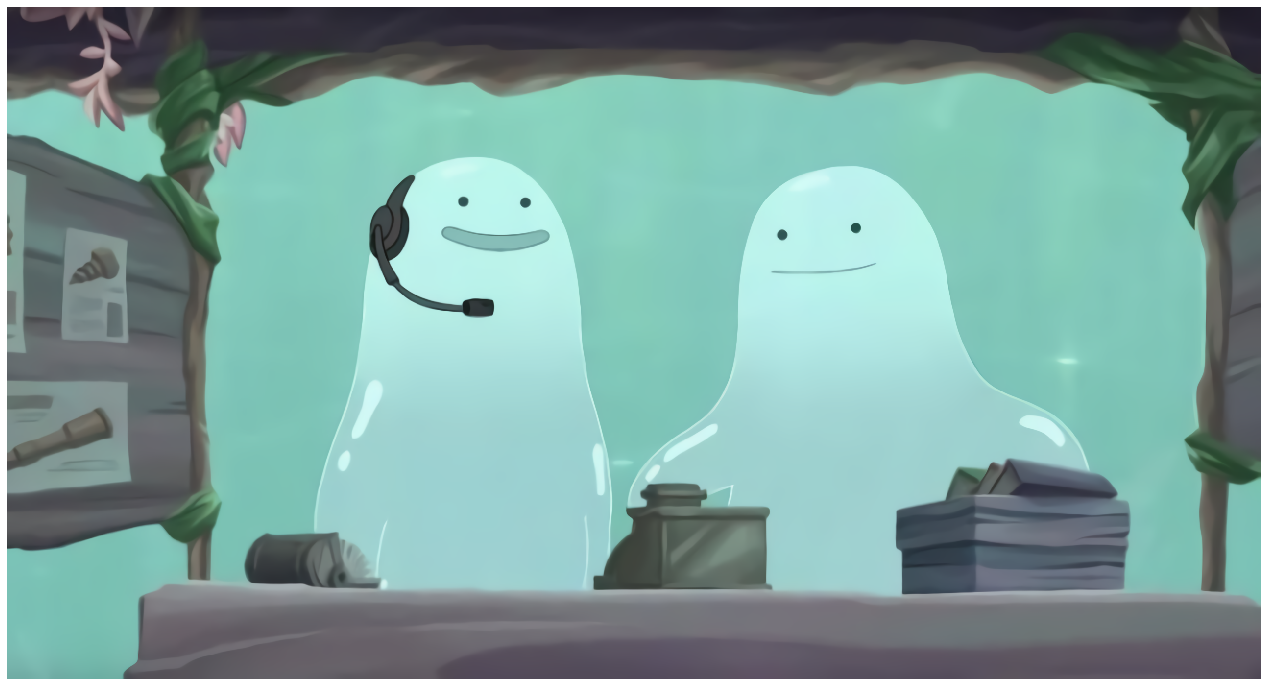

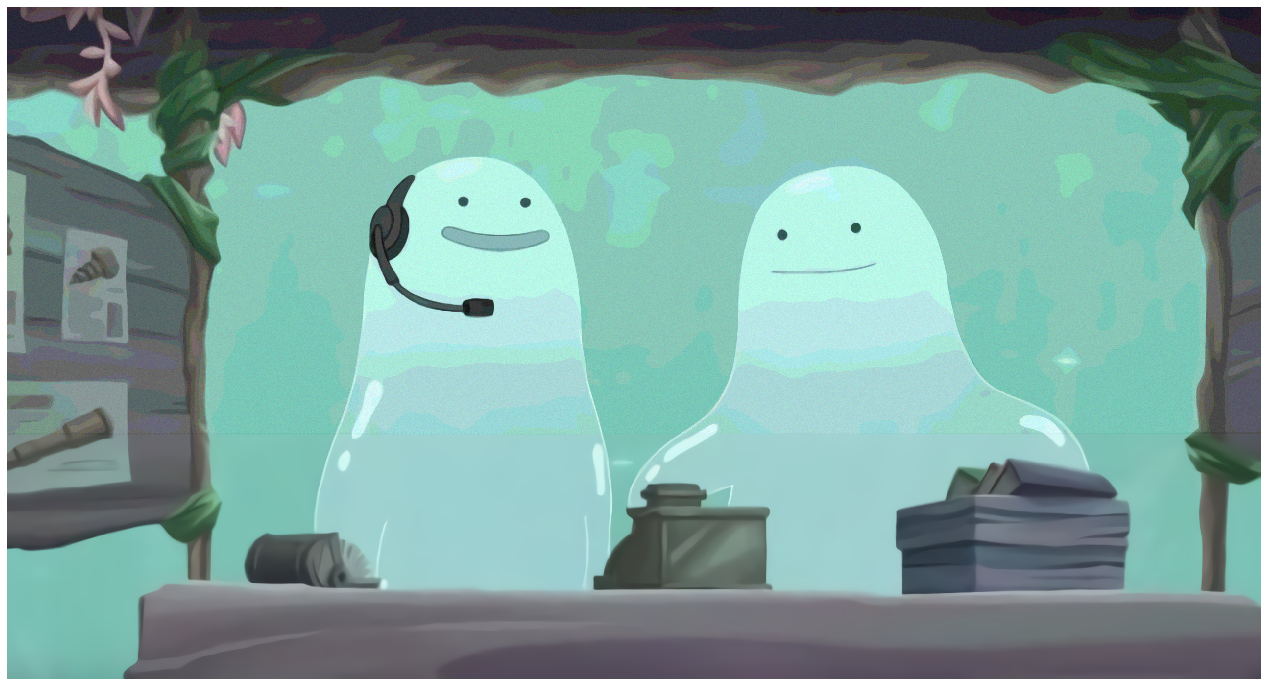

In [4]:
pltshow(dirPath(baseDir, "randall-2560x1372.png"), dim=(image.height, image.width))
pltshow(dirPath(encodedDir, "randall-L2.png"), dim=(image.height, image.width))

## Bit Plane Slicing

Since the LSB algorithm manipulates only a set of bits, bit plane slicing may be a useful technique in detecting the presence of hidden data.

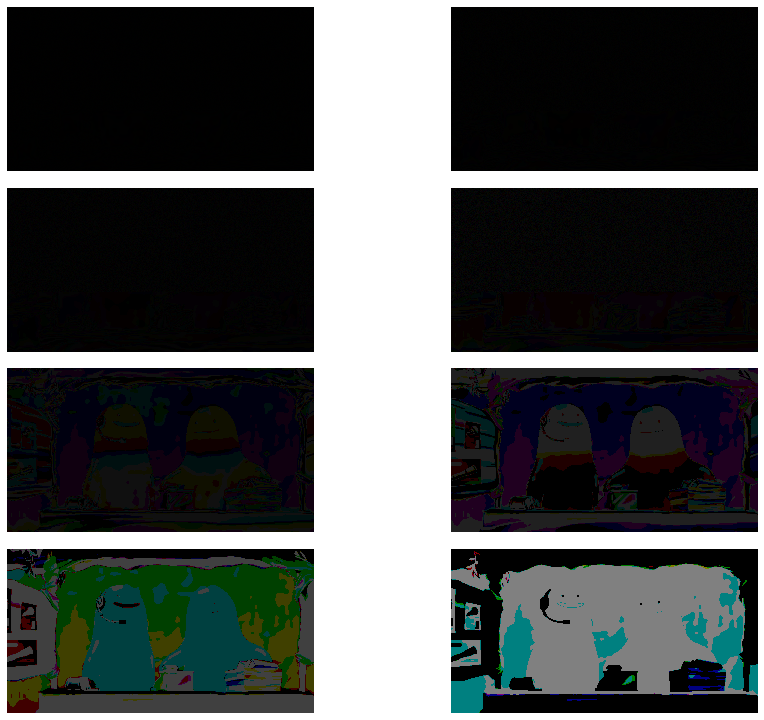

In [5]:
encodedImage = Image(dirPath(encodedDir, "randall-L2.png"))

mask = 0b00000001
plt.figure(figsize=(12, 10))
plt.subplots_adjust(left=.01, bottom=.01, right=.99, top=.99, wspace=.1, hspace=.1)
for i in range(8):
    bitPlane = encodedImage.data & (mask << i)
    
    plt.subplot(421 + i)
    plt.imshow(bitPlane)
    plt.axis("off")
plt.show()

Not very useful, as lesser significant bit planes represent a smaller range of values. This caveat can be overcome by normalizing all values.

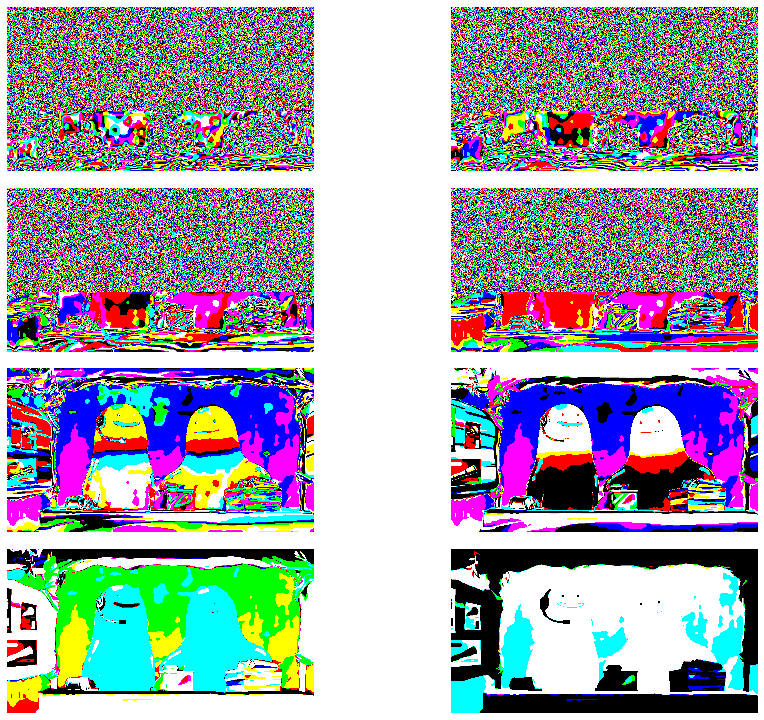

In [6]:
def normalize(img, c=0, d=255):
    a, b = img.min(), img.max()
    return (img-a)*((d-c)/(b-a)) + c

encodedImage = Image(dirPath(encodedDir, "randall-L2.png"))

mask = 0b00000001
plt.figure(figsize=(12, 10))
plt.subplots_adjust(left=.01, bottom=.01, right=.99, top=.99, wspace=.1, hspace=.1)
for i in range(8):
    bitSlice = normalize(encodedImage.data & (mask << i)).astype(np.uint8)
    
    plt.subplot(421 + i)
    plt.imshow(bitSlice)
    plt.axis("off")
plt.show()

That's better!

As per the presence of seemingly random data in the least significant bit planes, one could assume that there is something in there.

## Image Delta

As per the definition of the LSB method, each subpixel value in the image will change by, at most, $\pm (2^{n} - 1)$, with $n$ being the amount of manipulated bits. In doing so, each pixel's color may be converted to another one of ${(2^{n})}^3-1$ colors, or not change at all..

Furthermore, assuming some uniformly distributed random encoded data, replacing the last ${n}$ bits essentialy reduces the color space by a factor of ${{(2^n)}^3}$. This can be especially problematic and noticeable when dealing with gradient-heavy images, as the color boundaries, once subtle, are replaced with harshly more drastic ones.

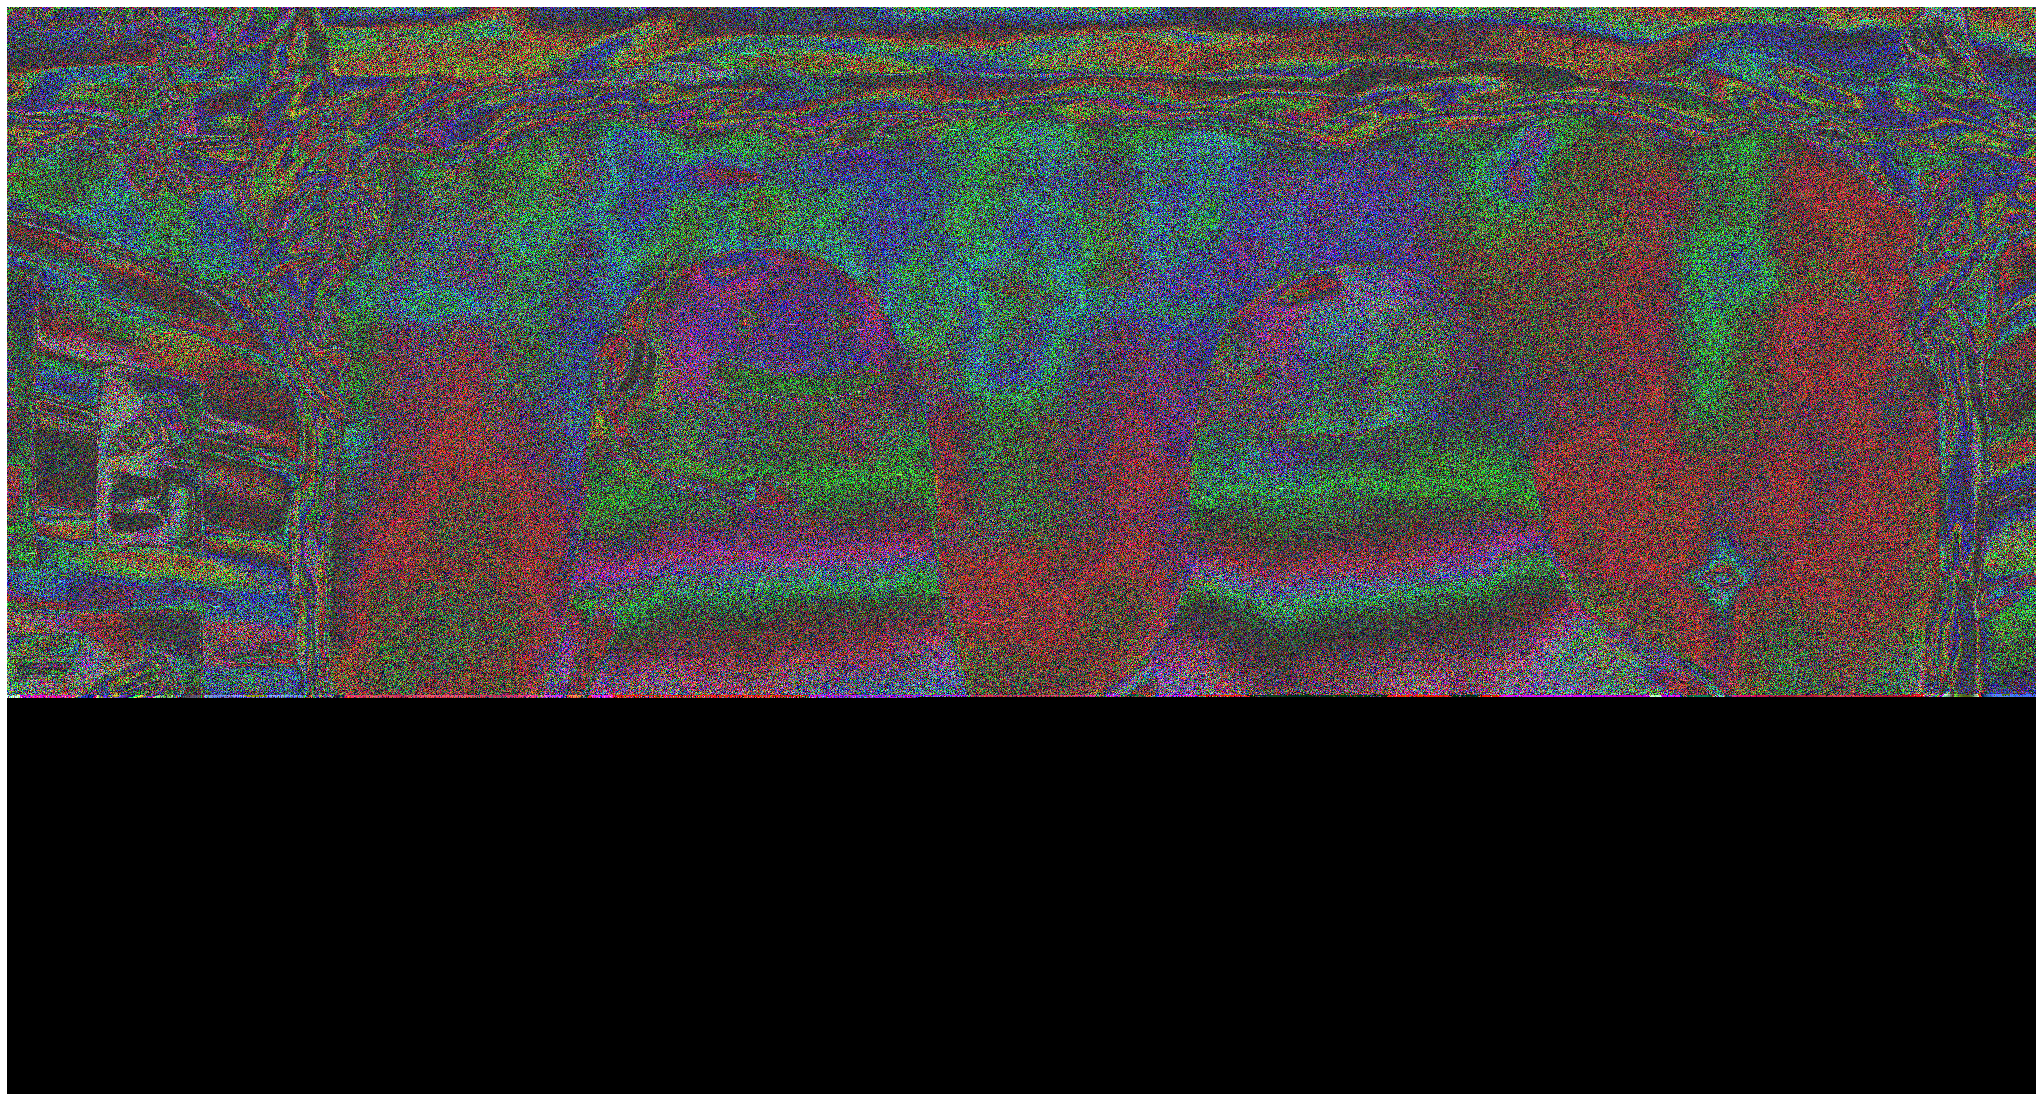

In [7]:
baseImage = Image(dirPath(baseDir, "randall-2560x1372.png"))
encodedImage = Image(dirPath(encodedDir, "randall-L2.png"))

diff = baseImage.data - encodedImage.data
diff[diff > 0xF0] = 0xFF - diff[diff > 0xF0]

plt.figure(figsize=(20 * baseImage.height/baseImage.width, 20))
plt.imshow(normalize(diff).astype(np.uint8))
plt.axis("off")
plt.show()

## Conclusions

* **LSB steganography** as a method of encryption relies heavily on [security through obscurity](https://en.wikipedia.org/wiki/Security_through_obscurity). As such, any and all attempts on elaborating on that are futile. A solution to that would be to pair the encoding with some actual encryption method - like simply zipping your payload with AES-256 before it, for example.

* The output image will always be PNG, as LSB depends on the exact color of every pixel - thus requiring no compression at all, or a lossless one. Compressing the resulting image down to a JPG, for example, would destroy the payload. Even in the case of the PNG compression, as the difference between neighboring pixels is greater, the compression ratio goes down, and file size goes up.

* Having the encoded data cut off halfway through the image is not always the best option. For that, the `fillRandom` argument of `Image.encodePayload()` can be set to `True`, so as to better mask the abrupt horizontal cutoff.

* Gradient-heavy images (e.g. abstract/artificial/computer-generated, cartoons) are the most affected by the encoding, in regards to naked-eye perception. Real-life pictures with encoded data can be less noticeable, as the payload can easily pass as [film grain](https://en.wikipedia.org/wiki/Film_grain).